In [1]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import yaml
import ast

In [2]:
%run ./src/database.py
%run ./src/util.py
%run ./src/data_preprocessing.py
%run ./src/feature_engineering.py
%run ./src/visualisation.py
%run ./src/model_build.py

In [3]:
YAML_FILEPATHNAME = "./config.yaml"
PRE_CRUISE_DB = 0
POST_CRUISE_DB = 1
IS_NOTEBOOK = True

# Read yaml config and data

In [4]:
# Read YAML file
yaml_data = read_yaml(YAML_FILEPATHNAME)
DISPLAY_STUB = yaml_data['display_stub']
DATA_PATH = yaml_data['data_path']
TEST_SIZE = yaml_data['test_size']
RANDOM_STATE = yaml_data['random_state']
TARGET_VARIABLE = yaml_data['target_variable']
DB_INFO = yaml_data['databases']
COMPOSITE_FIELD_INFO = yaml_data['composite_fields_to_split']
ID_FIELDS = ast.literal_eval(yaml_data['ID_columns'])
DATETIME_FIELD_INFO = yaml_data['convert_obj_datetime']
NUMERIC_FIELD_INFO = yaml_data['convert_obj_numeric']
MISSING_VAL_THRESHOLD =  yaml_data['pct_missing_threshold']
CONTINUOUS_VARIABLE = ast.literal_eval(yaml_data['continuous_variables'])
DIRTY_DATA_INFO = yaml_data['dirty_data_setting']
VALID_DATA_INFO = yaml_data['valid_data_setting']
NON_NUMERIC_COL = yaml_data['non_numeric_cols']
DATE_YYYY_INFO = yaml_data['convert_date_yyyy']

In [5]:
# Read Pre_cruise data
df_pre_cruise = db_read(DATA_PATH, DB_INFO[PRE_CRUISE_DB])

In [6]:
# Read Post_cruise data
df_post_cruise = db_read(DATA_PATH, DB_INFO[POST_CRUISE_DB])

# Preprocessing

In [7]:
# Merge Pre_cruise and Post_cruise to form df_cruise with Index as the key
df_cruise = db_merge_db (df_pre_cruise, df_post_cruise)

In [8]:
dp = DataProcessing(df_cruise, DISPLAY_STUB)

In [9]:
# Replace all np.nan to None
dp.replace_nan_none()

In [10]:
# Split composite field
dp.split_composite_field(COMPOSITE_FIELD_INFO)

In [11]:
# Remove IDs columns as in general they will have no predictive power
dp.rm_id_cols(ID_FIELDS)

In [12]:
# Column pruning due to high missing values.
dp.rm_cols_high_missing(MISSING_VAL_THRESHOLD)

In [13]:
# Convert fields from Object to Datetime
dp.obj_to_datetime(DATETIME_FIELD_INFO)

In [14]:
# Convert fields from Object to Numeric 
dp.numeric_conversion(NUMERIC_FIELD_INFO)

In [15]:
# Remove of rows from Target Variable 
dp.rm_rows_target_var(TARGET_VARIABLE)

In [16]:
# Removal of rows from Continuous variable which has missing value 
dp.remove_missing(CONTINUOUS_VARIABLE)

In [17]:
# Dirty Data Cleansing
dp.dirty_data_processing(DIRTY_DATA_INFO)

In [18]:
# Restriction of Column vales
dp.valid_data_processing(VALID_DATA_INFO)

In [19]:
var_name='Cleanliness'

In [20]:
# dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
# print(dp_data[var_name].isnull().sum())

In [21]:
dp.impute_missing_value(impute_type="random", col_list=['Gender','Online Check-in','Baggage handling','Cleanliness'])
dp.impute_missing_value(impute_type="mode", col_list=['Cruise Name','Onboard Wifi Service', 'Ease of Online booking',
                                                      'Embarkation/Disembarkation time convenient', 'Gate location',
                                                     'Onboard Dining Service','Cabin Comfort','Onboard Entertainment',
                                                     'Cabin service','Port Check-in Service','Onboard Service'])
# dp.impute_missing_value(impute_type="mean", col_list=['Distance'])

In [23]:
dp_data=dp.get_dataframe()
# print(dp_data[var_name].unique())
# vs_countplot(dp_data,[var_name], True)
print(dp_data.isnull().sum())
print("There are {} rows".format(dp_data.shape[0]))

Gender                                            0
Date of Birth                                     0
Onboard Wifi Service                              0
Embarkation/Disembarkation time convenient        0
Ease of Online booking                            0
Gate location                                     0
Logging                                           0
Onboard Dining Service                            0
Online Check-in                                   0
Cabin Comfort                                     0
Onboard Entertainment                             0
Cabin service                                     0
Baggage handling                                  0
Port Check-in Service                             0
Onboard Service                                   0
Cleanliness                                       0
Cruise Name                                       0
Ticket Type                                       0
Dining                                            0
Source      

In [23]:
# Label encode non-numeric categorical columns to get numeric values
dp.label_encoder(NON_NUMERIC_COL)

In [24]:
# Derive year from date column to enhance model efficiency, mitigate noise
dp.yyyy_from_date(DATE_YYYY_INFO)

# Feature Engineering

In [25]:
fe = feature_engineering(dp.get_dataframe())

In [29]:
temp1 = fe.get_dataframe()

In [31]:
temp1.head(5)

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Ticket Type,Dining,Source,Distance,Dist_Metrics,Year of Birth,Year of Logging,Traffic_1,Traffic_2,Traffic_3
index,,,,,,,,,,,,,,,,,,,,,
3,0,4,4.0,4.0,4.0,3,4.0,4.0,4,4.0,...,0,0,0,280.0,0,1970,2023,False,False,False
4,1,3,4.0,2.0,3.0,2,2.0,4.0,2,3.0,...,2,1,0,1145.0,1,1960,2023,False,False,False
6,1,3,5.0,3.0,3.0,4,5.0,4.0,4,4.0,...,2,1,0,607.0,0,1986,2023,True,False,False
8,0,1,4.0,3.0,4.0,4,1.0,2.0,1,5.0,...,0,0,0,<NA>,2,1981,2023,True,False,False
9,0,2,4.0,3.0,1.0,3,5.0,3.0,4,4.0,...,1,0,0,<NA>,2,1980,2023,False,False,False


In [28]:
fe.one_hot_key_encode(["Traffic"])

In [32]:
dp.get_dataframe()

,Gender,Onboard Wifi Service,Embarkation/Disembarkation time convenient,Ease of Online booking,Gate location,Onboard Dining Service,Online Check-in,Cabin Comfort,Onboard Entertainment,Cabin service,...,Cleanliness,Cruise Name,Ticket Type,Dining,Source,Traffic,Distance,Dist_Metrics,Year of Birth,Year of Logging
index,,,,,,,,,,,,,,,,,,,,,
3,0,4,4.0,4.0,4.0,3,4.0,4.0,4,4.0,...,4.0,1,0,0,0,0,280.0,0,1970,2023
4,1,3,4.0,2.0,3.0,2,2.0,4.0,2,3.0,...,3.0,1,2,1,0,0,1145.0,1,1960,2023
6,1,3,5.0,3.0,3.0,4,5.0,4.0,4,4.0,...,4.0,1,2,1,0,1,607.0,0,1986,2023
8,0,1,4.0,3.0,4.0,4,1.0,2.0,1,5.0,...,1.0,0,0,0,0,1,<NA>,2,1981,2023
9,0,2,4.0,3.0,1.0,3,5.0,3.0,4,4.0,...,3.0,0,1,0,0,0,<NA>,2,1980,2023
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
133734,0,0,1.0,1.0,1.0,2,4.0,4.0,4,2.0,...,2.0,0,1,1,0,1,1900.0,0,1979,2023
133739,0,0,5.0,2.0,1.0,4,4.0,5.0,4,4.0,...,4.0,0,2,0,0,0,2717.0,0,1962,2023
133740,1,3,3.0,3.0,3.0,3,4.0,3.0,3,3.0,...,3.0,0,2,1,0,0,<NA>,2,1987,2023


In [33]:
# Standardise distance by converting Mile to KM
fe.convert_miles_to_KM("Distance")

In [34]:
# Derive Age from Year of Birth and Year of Logging
fe.calc_year_diff('Year of Logging', 'Year of Birth', 'Age')

In [35]:
# Compute number of column
# fe.denote_missing_col()

#### Gender

In [36]:
fe.impute_missing_value(impute_type="mean")

# Model Building

Classification Report 
Train 
              precision    recall  f1-score   support

           0       0.66      0.67      0.66     35385
           1       0.72      0.72      0.72     35385
           2       0.64      0.63      0.64     35385

    accuracy                           0.67    106155
   macro avg       0.67      0.67      0.67    106155
weighted avg       0.67      0.67      0.67    106155

Test 
              precision    recall  f1-score   support

           0       0.13      0.31      0.19      1389
           1       0.80      0.71      0.75      8829
           2       0.71      0.64      0.67      8326

    accuracy                           0.65     18544
   macro avg       0.55      0.55      0.54     18544
weighted avg       0.71      0.65      0.68     18544


Confusion Metric
Train


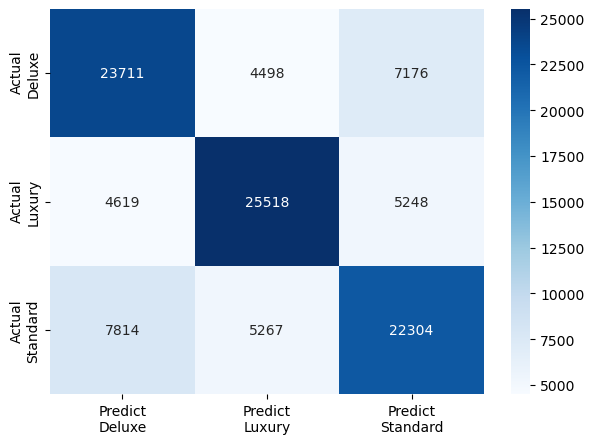

Test


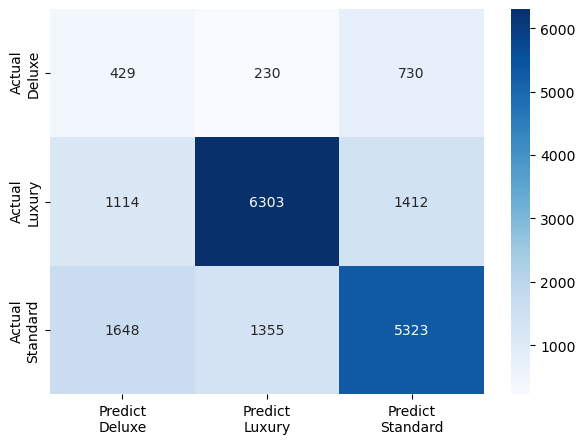


Performance Metrics
Train 
Test Accuracy: 0.6739
Test Precision: 0.6739
Test Recall: 0.6739
Test 
Test Accuracy: 0.6501
Test Precision: 0.6501
Test Recall: 0.6501


In [37]:
lr = Logistic_Regression(fe.get_dataframe())
X, y = lr.prepare_data(TARGET_VARIABLE)
hyperparameter_dict = {
    'random_state': RANDOM_STATE,
    'max_iter': 10000
}

lr.model_processing(X, y, TEST_SIZE, RANDOM_STATE, hyperparameter_dict, IS_NOTEBOOK)

In [38]:
# dtc = Decision_Tree(fe.get_dataframe())
# X, y = dtc.prepare_data(TARGET_VARIABLE)
# hyperparameter_dict = {
# }
# dtc.model_processing(X, y, TEST_SIZE, RANDOM_STATE, hyperparameter_dict, IS_NOTEBOOK)

In [39]:

# columns = X_train.columns
# os_data_X,os_data_y=os.fit_resample(X_train, y_train)
# os_data_X = pd.DataFrame(data=os_data_X,columns=columns )
# os_data_y= pd.DataFrame(data=os_data_y,columns=['y'])


# Model Evaluation